<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

# O cenário da cidade do Rio de Janeiro: rede escolar

- Continuando a criação de cenários que sejam **múltiplos** do cenário `Pop350` visto anteriormente.

- Neste segundo caderno da série, ...

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../../..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 09/Jun/2020


## Distribuição populacional da cidade do Rio de Janeiro

Primeiramente, conforme feito anteriormente:

- posicionamos as residências;

- distribuímos os indivíduos em suas residências; e 

- posicionamos os indivíduos em torno de suas residências.

### Carregando os dados

Carregamos os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro obtidos do [Landscan](https://landscan.ornl.gov), mudando para 0 o valor das células com -1.

In [5]:
landscan_rio = np.load('../../../../dados/RJ/cidade_rj/dados_estatisticos/LandScan.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)

Carregamos os dados de escolas por quilômetro quadrado da cidade do Rio de Janeiro, obtidos do [IPP/Data Rio](https://www.data.rio/datasets/escolas-municipais)

In [6]:
escolas_municipais = np.load('../../../../dados/RJ/cidade_rj/dados_estatisticos/Municipais.npy').astype(int)

### Visualização em escala logarítmica

Visualizamos 

$$ ln( 1 + \textrm{população})
$$

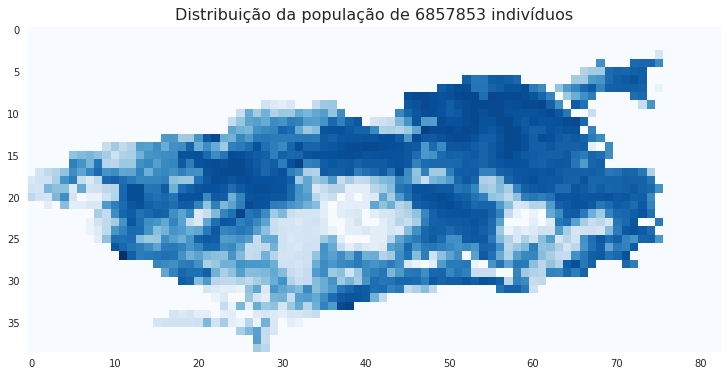

In [7]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + landscan_rio), cmap='Blues', interpolation='none')
plt.grid(False)
plt.title(f'Distribuição da população de {int(landscan_rio.sum())} indivíduos', fontsize=16)
plt.show()

## Rede residencial

Montamos a rede residencial como antes.

O importante para a montagem da rede de empresas não é a rede residencial em si, apenas a localização dos indivíduos feita na construção da rede residencial.

### Reduzindo a população

Com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator. 

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [8]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])
pop_por_blocos = (landscan_rio/100).astype(int)

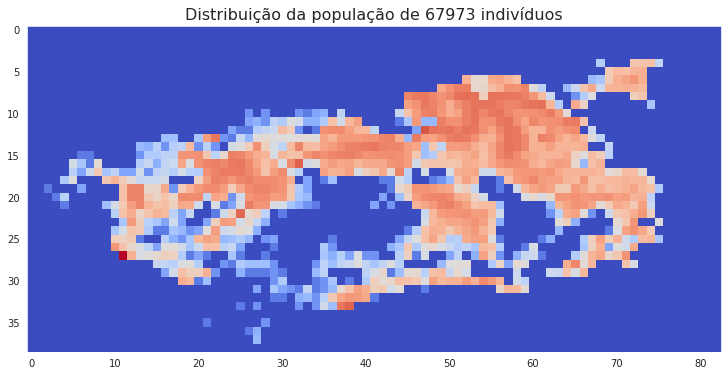

In [9]:
plt.figure(figsize=(16,6))
plt.imshow(np.log(1 + pop_por_blocos), cmap='coolwarm', interpolation='none')
#plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição da população de {pop_por_blocos.sum()} indivíduos', fontsize=16)
plt.show()

### Distribuindo e alocando os indivíduos e as suas residências

In [10]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_blocos, censo_residencial)

CPU times: user 502 ms, sys: 20.6 ms, total: 523 ms
Wall time: 525 ms


In [11]:
pop_blocos_indices[-1]

67973

### Gerando o grafo da rede residencial

In [12]:
%%time
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(pop_por_blocos), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos if i < j])

CPU times: user 252 ms, sys: 11 ms, total: 263 ms
Wall time: 270 ms


### Viualização

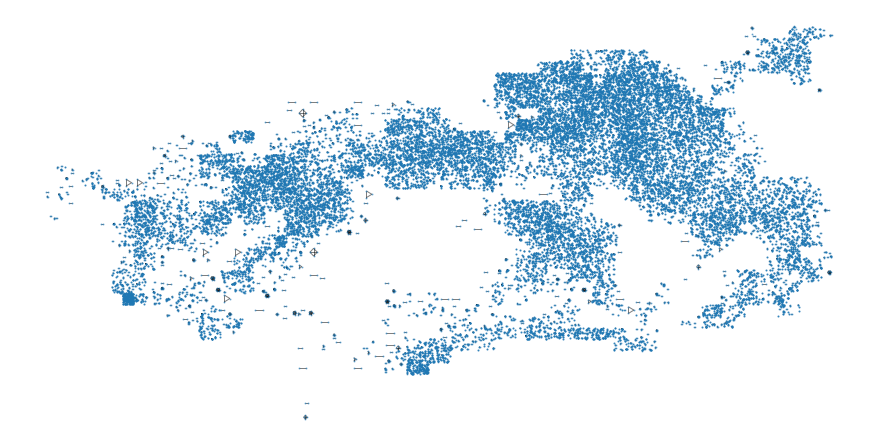

CPU times: user 1.06 s, sys: 160 ms, total: 1.22 s
Wall time: 924 ms


In [13]:
%%time
plt.figure(figsize=(12,6))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
plt.show()

## Rede escolar

Na construção da rede escolar, a ideia é fazer os seguintes passos:

- Temos as distribuições geolocalizadas das escolas.

- A partir do censo de idade populacional, determinar a parte da população a ser alocada nas escolas

- Para alocar a população nas escolas: Calculamos a distância de cada individuo para todas as escolas, e tomamos as 3 escolas mais próximas. Feito isso é selecionao uma das 3 escolas de maneira aleatória

- Para o cenário múltiplo de `Pop350`, fazemos uma redução proporcional no número de escolas com a função `random.choices`

### Redução no número de escolas

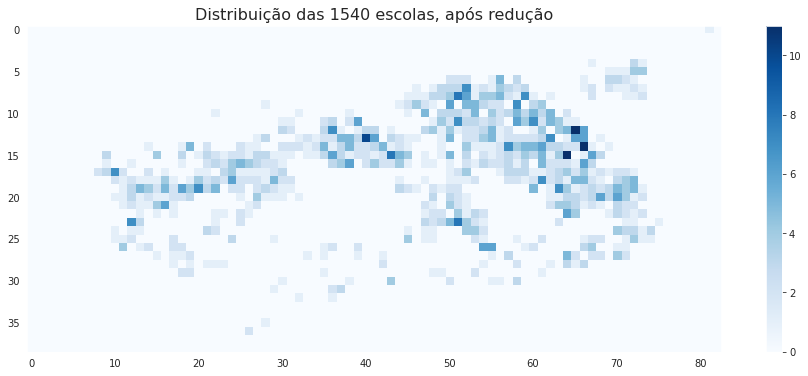

In [29]:
plt.figure(figsize=(16,6))
plt.imshow(escolas_municipais, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {escolas_municipais.sum()} escolas, após redução', fontsize=16)
plt.show()

In [14]:
rng_escolas = np.arange(np.prod(np.shape(escolas_municipais)))
weight_escolas = (escolas_municipais/np.sum(escolas_municipais)).flatten()

index_escolas = rng_escolas[weight_escolas != 0]  ## Guardando o indice das escolas
weight_escolas = weight_escolas[weight_escolas != 0]

In [34]:
## Escolhendo as escolas
esc_escolha = np.array(random.choices(index_escolas, weight_escolas, k = np.floor(np.sum(escolas_municipais*2/100)).astype(int)))

In [16]:
# Retornando as escolas à matriz 83x39
row_escolas = np.floor(esc_escolha/83)
col_escolas = np.mod(esc_escolha,83)
escolas_municipais_por_blocos = np.zeros((39,83))
for i,j in zip(row_escolas,col_escolas):
    escolas_municipais_por_blocos[int(i)][j] += 1

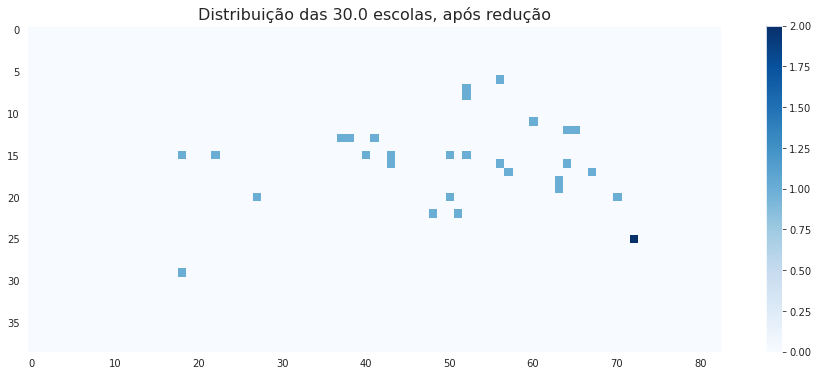

In [17]:
plt.figure(figsize=(16,6))
plt.imshow(escolas_municipais_por_blocos, cmap='Blues', interpolation='none')
plt.colorbar()
plt.grid(False)
plt.title(f'Distribuição das {escolas_municipais_por_blocos.sum()} escolas, após redução', fontsize=16)
plt.show()

## População ativa na educação básica

In [18]:
censo_fracoes = np.array([0.15079769082144653,  # 0 a 9 anos
                 0.17906470565542282,  # 10 a 19 anos
                 0.18007108135150324,  # 20 a 29 anos
                 0.15534569934620965,  # 30 a 39 anos
                 0.13023309451263393,  # 40 a 49 anos
                 0.09654553673621215,  # 50 a 59 anos
                 0.059499784853198616, # 60 a 69 anos
                 0.033053176013799715, # 70 a 79 anos
                 0.015389230709573343  # 80 ou mais
                ])

In [19]:
num_pop = pop_por_blocos.sum()
print(num_pop)

67973


In [20]:
num_pop_0a19 = int(num_pop*np.sum(censo_fracoes[0:2])) # consideramos apenas de 0 a 19 anos 
print(f'População em idade ativa: {num_pop_0a19}')

População em idade ativa: 22421


In [21]:
p_esc_a_idades_grupos = np.array([0, 2, 6, 15, 19, 100])
p_esc_a_idades_fracoes_grupos = np.array([0, 0.9, .95, .95, 0])

In [22]:
p_esc_a_idades_fracoes = list()
for j in range(len(p_esc_a_idades_grupos)-1):
    p_esc_a_idades_fracoes += (p_esc_a_idades_grupos[j+1] - p_esc_a_idades_grupos[j]) \
        * [p_esc_a_idades_fracoes_grupos[j]]

#pea_idades_fracoes = np.array(pea_idades_fracoes)*idades_fracoes
p_esc_a_idades_fracoes = np.array(p_esc_a_idades_fracoes)
print(f'Fração da população na educação básica: {p_esc_a_idades_fracoes.sum():.1f} %')

Fração da população na educação básica: 15.9 %


## Alocando população escolar nas escolas

### Gerando a localização das escolas

In [23]:
pos_x_escolas_municipais = col_escolas + np.random.rand(30)
pos_y_escolas_municipais = row_escolas + np.random.rand(30)

In [24]:
pos_escolas_municipais = np.array([pos_x_escolas_municipais,pos_y_escolas_municipais]).T

In [45]:
pos_individuos_escolas = np.array(pos_individuos)
dist_indiv_esc = [np.linalg.norm(p_i - pos_escolas_municipais, axis = 1).argsort()[:3] for p_i in pos_individuos_escolas]

In [46]:
dist_indiv_esc

[array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13,  4, 29]),
 array([13

In [51]:
indiv_esc = [random.choices(i)[0] for i in dist_indiv_esc]

In [52]:
indiv_esc

[4,
 13,
 29,
 13,
 13,
 13,
 29,
 4,
 13,
 29,
 4,
 13,
 29,
 29,
 29,
 13,
 29,
 4,
 4,
 29,
 13,
 13,
 13,
 13,
 29,
 29,
 13,
 13,
 4,
 13,
 13,
 29,
 29,
 4,
 4,
 4,
 4,
 4,
 4,
 13,
 13,
 13,
 29,
 4,
 13,
 13,
 13,
 29,
 29,
 4,
 13,
 13,
 29,
 4,
 13,
 4,
 29,
 29,
 13,
 4,
 13,
 13,
 29,
 13,
 4,
 13,
 29,
 13,
 4,
 13,
 29,
 13,
 29,
 29,
 13,
 4,
 13,
 29,
 13,
 13,
 4,
 13,
 4,
 13,
 4,
 29,
 13,
 13,
 4,
 29,
 4,
 29,
 13,
 29,
 13,
 13,
 4,
 29,
 13,
 4,
 29,
 4,
 29,
 4,
 4,
 13,
 4,
 29,
 29,
 13,
 13,
 29,
 13,
 13,
 4,
 13,
 4,
 4,
 29,
 29,
 13,
 29,
 29,
 29,
 29,
 29,
 29,
 4,
 4,
 29,
 4,
 29,
 4,
 29,
 13,
 29,
 4,
 4,
 29,
 4,
 4,
 13,
 4,
 29,
 29,
 29,
 4,
 13,
 4,
 4,
 29,
 13,
 13,
 29,
 29,
 29,
 13,
 4,
 29,
 4,
 13,
 13,
 29,
 4,
 4,
 29,
 4,
 29,
 4,
 4,
 29,
 13,
 29,
 4,
 29,
 4,
 29,
 4,
 13,
 4,
 13,
 13,
 29,
 13,
 13,
 29,
 4,
 29,
 13,
 4,
 29,
 4,
 29,
 29,
 13,
 13,
 4,
 4,
 4,
 13,
 4,
 29,
 13,
 4,
 4,
 29,
 13,
 4,
 4,
 29,
 4,
 29,
 29,
 4,


In [53]:
#indiv_esc = [random.choices(np.linalg.norm(p_i - pos_escolas_municipais, axis = 1).argsort()[:3])[0] for p_i in pos_individuos_escolas]

---